In [1]:
import sys
sys.path.insert(0, '../')
from util import util_data_access

In [25]:
# download data
util_data_access.download_file('newssniffer-nytimes.db.gz', 'edit-pathways/dbs/newssniffer-nytimes.db.gz')
! gunzip newssniffer-nytimes.db.gz

INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): s3.dev.obdc.bcs.bloomberg.com
INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTP connection (2): s3.dev.obdc.bcs.bloomberg.com
INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTP connection (3): s3.dev.obdc.bcs.bloomberg.com
INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTP connection (4): s3.dev.obdc.bcs.bloomberg.com
INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTP connection (5): s3.dev.obdc.bcs.bloomberg.com
INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTP connection (6): s3.dev.obdc.bcs.bloomberg.com
INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTP connection (7): s3.dev.obdc.bcs.bloomberg.com
INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTP connection (8): s3.dev

gzip: newssniffer-nytimes.db already exists; do you wish to overwrite (y or n)? ^C


In [3]:
# util_data_access.download_file('glove-100d-loc.tar.gz', 'spark-nlp/glove-100d-loc.tar.gz')
# ! tar -xzvf glove-100d-loc.tar.gz 

# Load Spark

In [1]:
from pyspark.sql import SparkSession
# spark = sparknlp.start()

spark = (
    SparkSession.builder
      .config("spark.executor.instances", "30")
      .config("spark.driver.memory", "20g")
      .config("spark.executor.memory", "20g")
      .config("spark.sql.shuffle.partitions", "2000")
      .config("spark.executor.cores", "5")
      .config("spark.kryoserializer.buffer.max", "2000M")
      .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.11:2.7.5")
      .getOrCreate()
)

In [2]:
spark

# Load Our Own Data

In [3]:
import sqlite3
import pandas as pd
from tqdm.auto import tqdm
import pyspark.sql.functions as F
import sqlite3
import pandas as pd 


In [4]:
already_parsed = pd.read_csv('nyt-output-sentence-matching-1.csv', index_col=0)

In [5]:
with sqlite3.connect('newssniffer-nytimes.db') as conn:
    df = pd.read_sql("""
            with c1 as (
                SELECT e1.entry_id as entry_id,
                    e1.version as version_x,
                    e2.version as version_y,
                    e1.title as title_x,
                    e2.title as title_y
                FROM entryversion e1
                JOIN entryversion e2
                    ON e1.entry_id = e2.entry_id
                    AND (e1.version + 1) = e2.version
                WHERE e1.title != e2.title
                AND e1.entry_id NOT IN (%s)
                AND e1.num_versions < 40 AND e1.num_versions > 1
            )

            SELECT * from entryversion
            WHERE entry_id IN (select distinct entry_id from c1 limit 1000)
            AND version IN (select version_x from c1 union select version_y from c1)
        """ % ', '.join(map(str, already_parsed['entry_id'].drop_duplicates().tolist()))
        , con=conn
    )
    df = df.assign(summary=lambda df: df['summary'].str.replace('</p><p>', ' '))

In [39]:
with sqlite3.connect('newssniffer-nytimes.db') as conn:

    df = pd.read_sql('''
         SELECT * from entryversion 
         WHERE entry_id IN (
             SELECT distinct entry_id FROM entryversion LIMIT 5000)
     ''', con=conn)

#     df = pd.read_sql('''
#          SELECT * from entryversion 
#          WHERE entry_id IN (1951413, 1952324, 1969148, 1451793, 1938021)
#      ''', con=conn)
    # , 
    df = df.assign(summary=lambda df: df['summary'].str.replace('</p><p>', ' '))

In [7]:
sdf = spark.createDataFrame(df)

# With Sentences

In [10]:
from pyspark.ml.feature import Normalizer, SQLTransformer
from pyspark.ml.feature import BucketedRandomProjectionLSH
from scipy.spatial import distance
from pyspark.sql.types import FloatType
from scipy.spatial import distance
import sparknlp.base as sb
import sparknlp.annotator as sa

In [11]:
def get_word_matching_sql(side):
    """Generate the SQL necessary to transform each side. Side \in {'x', 'y'}"""
    
    word_pair_min_distance_sql = """
         SELECT entry_id,
                version_x,
                version_y,
                sent_idx_x,
                sent_idx_y,
                word_idx_%(side)s,
                MIN(num_words) as num_words_total_list,
                MIN(distance) as min_word_distance
        FROM __THIS__ 
        GROUP BY entry_id,
                version_x,
                version_y,
                sent_idx_x,
                sent_idx_y,
                word_idx_%(side)s
      """ % ({'side': side})
    
    sentence_pair_min_distance_sql = """
        SELECT entry_id,
               version_x,
               version_y,
               sent_idx_x,
               sent_idx_y,
               (sum_min_word_distance + .5 * ( num_words_total - num_matched_words )) / num_words_total AS avg_sentence_distance
        FROM (
           SELECT entry_id,
                  version_x,
                  version_y,
                  sent_idx_x,
                  sent_idx_y,
                  SUM(min_word_distance) AS sum_min_word_distance,
                  COUNT(1) AS num_matched_words,
                  MIN(num_words_total_list) AS num_words_total
           FROM __THIS__
                GROUP BY entry_id,
                   version_x,
                   version_y,
                   sent_idx_x,
                   sent_idx_y
          )
      """
    
    sentence_min_sql = """
         SELECT entry_id,
                version_x,
                version_y,
                sent_idx_x,
                sent_idx_y,
                avg_sentence_distance
           FROM (
                    SELECT *, ROW_NUMBER() OVER (
                         PARTITION BY entry_id, 
                                      version_x, 
                                      version_y, 
                                      sent_idx_%(side)s
                         ORDER BY avg_sentence_distance ASC
                ) AS rn FROM __THIS__
        )
         where rn = 1
    """ % ({'side': side})
    
    threshold_sql = """
         SELECT entry_id,
                version_x,
                version_y,
                sent_idx_%(join_side)s,
                CASE 
                    WHEN (avg_sentence_distance < .44 ) THEN sent_idx_%(other_side)s
                    ELSE NULL
                END AS sent_idx_%(other_side)s,
                CASE 
                    WHEN (avg_sentence_distance < .44 ) THEN avg_sentence_distance
                    ELSE NULL
                END AS avg_sentence_distance
            FROM __THIS__
    """ %({'join_side': side, 'other_side': list({'x', 'y'} - set(side))[0]})
    
    return word_pair_min_distance_sql, sentence_pair_min_distance_sql, sentence_min_sql, threshold_sql

### Steps

In [12]:
documenter = (
    sb.DocumentAssembler()
        .setInputCol("summary")
        .setOutputCol("document")
)

sentencer = (
    sa.SentenceDetector()
        .setInputCols(["document"])
        .setOutputCol("sentences")            
)

tokenizer = (
    sa.Tokenizer()
        .setInputCols(["sentences"])
        .setOutputCol("token")
)

word_embeddings = (
    sa.BertEmbeddings
        .load('s3://aspangher/spark-nlp/small_bert_L4_128_en_2.6.0_2.4')
        .setInputCols(["sentences", "token"])
        .setOutputCol("embeddings")
        .setMaxSentenceLength(512)
        .setBatchSize(100)
)

tok_finisher = (
    sb.Finisher()
    .setInputCols(["token"])
    .setIncludeMetadata(True)
)

embeddings_finisher = (
    sb.EmbeddingsFinisher()
            .setInputCols("embeddings")
            .setOutputCols("embeddings_vectors")
            .setOutputAsVector(True)
)

In [13]:
zip_tok = (
    SQLTransformer()
     .setStatement("""
         SELECT CAST(entry_id AS int) as entry_id,
                CAST(version AS int) as version, 
                ARRAYS_ZIP(finished_token, finished_token_metadata, embeddings_vectors) AS zipped_tokens
         FROM __THIS__
    """)
)

explode_tok = (
    SQLTransformer()
     .setStatement("""
         SELECT entry_id, version, POSEXPLODE(zipped_tokens) AS (word_idx, zipped_token)
         FROM __THIS__
    """)
)

rename_tok = (
    SQLTransformer()
     .setStatement("""
         SELECT entry_id, 
                 version,
                 CAST(zipped_token.finished_token_metadata._2 AS int) AS sent_idx,
                 COUNT(1) OVER(PARTITION BY entry_id, version, zipped_token.finished_token_metadata._2) as num_words,
                 CAST(word_idx AS int) word_idx,
                 zipped_token.finished_token AS token,
                 zipped_token.embeddings_vectors as word_embedding
         FROM __THIS__
    """)
) 

vector_normalizer = (
    Normalizer(
        inputCol="word_embedding", 
        outputCol="norm_word_embedding", 
        p=2.0
    )
)
similarty_checker = (
    BucketedRandomProjectionLSH(
        inputCol="norm_word_embedding", 
        outputCol="hashes", 
        bucketLength=3,
        numHashTables=3
    )
)

## get top sentences, X, pipeline
s1x, s2x, s3x, s4x = get_word_matching_sql(side='x')
get_word_pair_min_distance_x = SQLTransformer().setStatement(s1x)
get_sentence_min_distance_x = SQLTransformer().setStatement(s2x)
get_min_sentence_x = SQLTransformer().setStatement(s3x)
threshold_x = SQLTransformer().setStatement(s4x)

## get top sentences, Y, pipeline
s1y, s2y, s3y, s4y = get_word_matching_sql(side='y')
get_word_pair_min_distance_y = SQLTransformer().setStatement(s1y)
get_sentence_min_distance_y = SQLTransformer().setStatement(s2y)
get_min_sentence_y = SQLTransformer().setStatement(s3y)
threshold_y = SQLTransformer().setStatement(s4y)

In [14]:
sparknlp_processing_pipeline = sb.RecursivePipeline(stages=[
    documenter,
    sentencer,
    tokenizer,
    word_embeddings,
    embeddings_finisher,
    tok_finisher
  ]
)

explode_pipeline = sb.PipelineModel(stages=[
    zip_tok,
    explode_tok,
    rename_tok,
])

similarity_pipeline = sb.Pipeline(stages=[
    vector_normalizer,
    similarty_checker
])

top_sentence_pipeline_x = sb.PipelineModel(stages=[
    get_word_pair_min_distance_x,
    get_sentence_min_distance_x,
    get_min_sentence_x,
    threshold_x
])

top_sentence_pipeline_y = sb.PipelineModel(stages=[
    get_word_pair_min_distance_y,
    get_sentence_min_distance_y,
    get_min_sentence_y,
    threshold_y
])

In [15]:
## pipeline and cache
sdf = sdf.repartition('entry_id', 'version').cache()
spark_processed_df = sparknlp_processing_pipeline.fit(sdf).transform(sdf)
spark_processed_df = spark_processed_df.cache()

exploded_sdf = explode_pipeline.transform(spark_processed_df)
exploded_sdf = exploded_sdf.cache()

print('fitting LSH Pipeline...')
similarity_model = similarity_pipeline.fit(exploded_sdf)
sim_sdf = similarity_model.transform(exploded_sdf)

### for 1,000 records: LSH takes 2.7 min
### for 2,500 records, LSH takes 

sim_sdf = sim_sdf.repartition(
    'entry_id',
    'version',
).cache()

print('performing approximate join...')
## Approximate Join
word_pair_matched_sdf = (
    similarity_model
    .stages[1]
    .approxSimilarityJoin(sim_sdf, sim_sdf, .5, distCol="distance")
    .where((F.col("datasetA.entry_id") == F.col("datasetB.entry_id")) & (F.col("datasetA.version") + 1 == F.col("datasetB.version")))
    .select(
         F.col("datasetA.entry_id").alias("entry_id"),
         F.col("datasetA.version").alias("version_x"),
         F.col("datasetB.version").alias("version_y"),
         F.col("datasetA.sent_idx").alias("sent_idx_x"),
         F.col("datasetB.sent_idx").alias("sent_idx_y"),        
         F.col("datasetA.word_idx").alias("word_idx_x"),
         F.col("datasetB.word_idx").alias("word_idx_y"),
         F.col("datasetA.num_words").alias("num_words"),
         F.col("datasetA.token").alias("token_x"),
         F.col("datasetB.token").alias("token_y"),
         F.col("distance")
    )
)

word_pair_matched_sdf = word_pair_matched_sdf.repartition(
                        'entry_id',
                        'version_x',
                        'version_y',
                        'sent_idx_x',
                        'sent_idx_y',
#                         'word_idx_x',
#                         'word_idx_y',
).cache()

## performing bipartite matching
sent_pairs_x_sdf = top_sentence_pipeline_x.transform(word_pair_matched_sdf).cache()
sent_pairs_y_sdf = top_sentence_pipeline_y.transform(word_pair_matched_sdf).cache()

## 
join_cols=['entry_id', 'version_x', 'version_y', 'sent_idx_x', 'sent_idx_y']
final_sdf = (
 sent_pairs_x_sdf
    .withColumnRenamed('avg_sentence_distance', 'avg_sentence_distance_x')
    .join(
    sent_pairs_y_sdf.withColumnRenamed('avg_sentence_distance', 'avg_sentence_distance_y', ),
    on=join_cols, 
    how='outer'
).dropDuplicates(join_cols))

## to pandas
print('to pandas...')
final_dfp = final_sdf.toPandas()

fitting LSH Pipeline...
performing approximate join...
to pandas...


Py4JJavaError: An error occurred while calling o597.collectToPython.
: org.apache.spark.SparkException: Job 3 cancelled 
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1889)
	at org.apache.spark.scheduler.DAGScheduler.handleJobCancellation(DAGScheduler.scala:1824)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2076)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2048)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2126)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:945)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:944)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:299)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3263)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3260)
	at org.apache.spark.sql.Dataset$$anonfun$52.apply(Dataset.scala:3370)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:78)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:73)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3369)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3260)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)


In [28]:
final_dfp.to_csv('nyt-output-sentence-matching-.csv')

In [314]:
final_df_3_3 = final_sdf.toPandas()

In [280]:
final_df_6_6 = final_sdf.toPandas()

In [315]:
final_df_3_3.head()

,entry_id,version_x,version_y,sent_idx_x,sent_idx_y,avg_sentence_distance_x,avg_sentence_distance_y
0,1951413,17,18,27.0,27.0,0.000000e+00,0.000000e+00
1,1952324,13,14,80.0,78.0,3.021371e-07,3.021371e-07
2,1952324,5,6,47.0,47.0,0.000000e+00,0.000000e+00
3,1951413,5,6,15.0,15.0,0.000000e+00,0.000000e+00
4,1951413,4,5,14.0,14.0,0.000000e+00,0.000000e+00


In [283]:
final_df_6_6.head()

,entry_id,version_x,version_y,sent_idx_x,sent_idx_y,avg_sentence_distance_x,avg_sentence_distance_y
0,1952324,5,6,47.0,47.0,0.000000e+00,0.000000e+00
1,1951413,17,18,27.0,27.0,0.000000e+00,0.000000e+00
2,1952324,13,14,80.0,78.0,3.021371e-07,3.021371e-07
3,1951413,5,6,35.0,38.0,0.000000e+00,0.000000e+00
4,1951413,4,5,14.0,14.0,0.000000e+00,0.000000e+00


# Check if reducing bucket size makes a difference

In [336]:
(final_df_1_1[cols]
 .rename({'sent_idx_x': 'sent_x_1_1', 'sent_idx_y': 'sent_y_1_1'}, axis=1)
 .merge(
    final_df_6_6[cols].rename({'sent_idx_x': 'sent_x_6_6', 'sent_idx_y': 'sent_y_6_6'}, axis=1),
    right_on=['entry_id', 'version_x', 'version_y', 'sent_x_6_6'],
    left_on=['entry_id', 'version_x', 'version_y', 'sent_x_1_1'],
    how='outer'
)
 .loc[lambda df: df['sent_y_1_1'] != df['sent_y_6_6']]
 .loc[lambda df: ~( df['sent_x_1_1'].isnull() & df['sent_y_1_1'].notnull())]
 .loc[lambda df: ~( df['sent_x_1_1'].notnull() & df['sent_y_1_1'].isnull())]
#  .dropna()
)

,entry_id,version_x,version_y,sent_x_1_1,sent_y_1_1,sent_x_6_6,sent_y_6_6
4851,1952324,0,1,38.0,41.0,38.0,40.0


In [339]:
(final_df_1_1
 .loc[lambda df: df['entry_id'] == 1952324]
 .loc[lambda df: df['version_x'] == 0]
 .loc[lambda df: df['version_y'] == 1]
 .loc[lambda df: df['sent_idx_x'] == 38]
)

,entry_id,version_x,version_y,sent_idx_x,sent_idx_y,avg_sentence_distance_x,avg_sentence_distance_y
3064,1952324,0,1,38.0,41.0,0.388997,0.388997


In [340]:
(final_df_3_3
 .loc[lambda df: df['entry_id'] == 1952324]
 .loc[lambda df: df['version_x'] == 0]
 .loc[lambda df: df['version_y'] == 1]
 .loc[lambda df: df['sent_idx_x'] == 38]
)

,entry_id,version_x,version_y,sent_idx_x,sent_idx_y,avg_sentence_distance_x,avg_sentence_distance_y
541,1952324,0,1,38.0,40.0,NaN,0.439192
3064,1952324,0,1,38.0,41.0,0.388997,0.388997


In [316]:
(final_df_3_3[cols]
 .rename({'sent_idx_x': 'sent_x_3_3', 'sent_idx_y': 'sent_y_3_3'}, axis=1)
 .merge(
    final_df_6_6[cols].rename({'sent_idx_x': 'sent_x_6_6', 'sent_idx_y': 'sent_y_6_6'}, axis=1),
    right_on=['entry_id', 'version_x', 'version_y', 'sent_x_6_6'],
    left_on=['entry_id', 'version_x', 'version_y', 'sent_x_3_3'],
)
 .loc[lambda df: df['sent_y_3_3'] != df['sent_y_6_6']]
 .dropna()
)

,entry_id,version_x,version_y,sent_x_3_3,sent_y_3_3,sent_x_6_6,sent_y_6_6
2378,1952324,0,1,38.0,40.0,38.0,41.0
2379,1952324,0,1,38.0,41.0,38.0,40.0


In [317]:
(final_df_3_3[cols]
 .rename({'sent_idx_x': 'sent_x_3_3', 'sent_idx_y': 'sent_y_3_3'}, axis=1)
 .merge(
    final_df_6_6[cols].rename({'sent_idx_x': 'sent_x_6_6', 'sent_idx_y': 'sent_y_6_6'}, axis=1),
    right_on=['entry_id', 'version_x', 'version_y', 'sent_y_6_6'],
    left_on=['entry_id', 'version_x', 'version_y', 'sent_y_3_3'],
)
 .loc[lambda df: df['sent_x_3_3'] != df['sent_x_6_6']]
 .dropna()
)

,entry_id,version_x,version_y,sent_x_3_3,sent_y_3_3,sent_x_6_6,sent_y_6_6
101,1952324,4,5,25.0,25.0,24.0,25.0
102,1952324,4,5,24.0,25.0,25.0,25.0
2140,1951413,12,13,79.0,73.0,72.0,73.0
2141,1951413,12,13,72.0,73.0,79.0,73.0
3048,1952324,0,1,7.0,8.0,8.0,8.0
3049,1952324,0,1,8.0,8.0,7.0,8.0
3412,1951413,5,6,64.0,67.0,67.0,67.0
3413,1951413,5,6,67.0,67.0,64.0,67.0
4066,1951413,1,2,22.0,52.0,18.0,52.0
4067,1951413,1,2,18.0,52.0,22.0,52.0


In [224]:
final_df_3_3 = final_df 

# Get Sentences for Inspection

In [368]:
normer = (
    sa.DocumentNormalizer()
    .setInputCols(["document"])
    .setOutputCol("normed_document")
    .setPatterns(["[^\w\d\s\.\,\"\']"])
#     .setPolicy('pretty_all')
)

sentencer = (
    sa.SentenceDetector()
        .setInputCols(["document"])
        .setOutputCol("sentences")            
)

sentencer_dl = (
    sa.SentenceDetectorDLModel
        .load('s3://aspangher/spark-nlp/sentence_detector_dl_en')
        .setInputCols(["document"])
        .setOutputCol("sentences")            
)

sent_finisher = (
    sb.Finisher()
    .setInputCols(["sentences"])
)

explode_sent = (
    SQLTransformer()
     .setStatement("""
         SELECT entry_id, version, POSEXPLODE(finished_sentences) AS (sent_idx, sentence)
         FROM __THIS__
    """)
)

sentence_splitter_pipeline = sb.RecursivePipeline(stages=[
    documenter,
    sentencer_dl,
    sent_finisher,
    explode_sent
])

In [369]:
sent_dfp = sentence_splitter_pipeline.fit(sdf).transform(sdf).toPandas()

In [345]:
# sent_dfp[['entry_id', 'version_x', 'version_y']].drop_duplicates().head(10)

# Compare Sentences

In [346]:
from IPython.display import display, HTML
import sys
sys.path.append('..')
## download spacy model 
# download data
from util import util_data_access
import os
if not os.path.exists('en_core_web_lg'):
    util_data_access.download_file('en_core_web_lg.tar.gz', 'edit-pathways/spacy/en_core_web_lg.tar.gz')
    ! tar -xf en_core_web_lg.tar.gz
    ! mv en_core_web_lg-2.3.1 en_core_web_lg
import util.util_newssniffer_parsing as unp

In [ ]:
# (final_df_3_3
#  .loc[lambda df: df['entry_id'] == 1952324]
#  .loc[lambda df: df['version_x'] == 0]
#  .loc[lambda df: df['version_y'] == 1]
#  .loc[lambda df: df['sent_idx_x'] == 38]
# )

In [352]:
# (sent_dfp
#  .loc[lambda df: df['entry_id'] == 1952324]
#  .loc[lambda df: df['version_x'] == 0]
#  .loc[lambda df: df['version_y'] == 1]
# )

In [355]:
comp_sents = (final_df_3_3
 .loc[lambda df: df['entry_id'] == 1952324]
 .loc[lambda df: df['version_x'] == 0]
 .loc[lambda df: df['version_y'] == 1]
 .merge(
    sent_dfp,
    left_on=['entry_id', 'version_x', 'sent_idx_x'],
    right_on=['entry_id', 'version', 'sent_idx'],
    how='left'
 ).drop(['version', 'sent_idx',], axis=1)
 .merge(
    sent_dfp, 
    left_on=['entry_id', 'version_y', 'sent_idx_y'],
    right_on=['entry_id', 'version', 'sent_idx'],
    how='left'
 )
 .drop(['version', 'sent_idx',], axis=1)
 .sort_values(['sent_idx_x', 'sent_idx_y'])
)

In [361]:
s1

'What happened in Minneapolis and elsewhere this week reflected the broad and diverse scope of the movement that took flight six years ago, with young but already veteran organizers trying to keep the focus on police accountability and systemic racism through chanting and marching.'

In [363]:
s2 or ''

nan

In [364]:
html = [
    '<table>',
    '<tr><th>SIdx Old</th><th>Old Version</th><th>New Version</th><th>SIdx New</th><th>Distance</th></tr>',
]
for s_idx_1, s_idx_2, s1, s2, d in (
        comp_sents
            [['sent_idx_x', 'sent_idx_y', 'sentence_x', 'sentence_y', 'avg_sentence_distance_x']]
    .fillna('')
#             .loc[lambda df: df['avg_sentence_distance_x'] > .44]
            .itertuples(index=False)
):
    one_row = '<tr><td>%s</td><td>%s</td><td>%s</td><td>%s</td><td>%s</td></tr>'
    w1, w2 = unp.get_words(s1), unp.get_words(s2)
    hs1, hs2 = unp.html_compare_sentences(*unp.get_list_diff(w1, w2))
    html.append(one_row % (s_idx_1, hs1, hs2, s_idx_2, d))
    
html_output = ''.join(html).replace('$', r'\$')

In [365]:
display(HTML(html_output))

# 38.0	40.0	38.0	41.0

SIdx Old,Old Version,New Version,SIdx New,Distance
0.0,"MINNEAPOLIS — With the Third Police Precinct headquarters engulfed in flames , a cathartic release swept through the streets of Minneapolis ’s South Side Thursday night .","MINNEAPOLIS — With the Third Police Precinct headquarters engulfed in flames , what felt like a cathartic release swept through the streets of Minneapolis ’s South Side on Thursday night .",0.0,0.21324550597266542
1.0,"Some people danced to Beyoncé , others passed out beer .","Some people danced to Beyoncé , others passed out beer .",1.0,0.0
2.0,"Still others chanted : “ No justice , no peace !","Still others chanted : “ No justice , no peace !",2.0,0.0
3.0,"Prosecute the police ! ” The police killing of George Floyd in Minneapolis has incited a wave of demonstrations and unrest across the nation , renewing passionate street uprisings that gave rise to the Black Lives Matter movement six years ago .","Prosecute the police ! ” The police killing of George Floyd in Minneapolis has incited a wave of demonstrations and unrest across the nation , renewing passionate street uprisings that gave rise to the Black Lives Matter movement six years ago .",3.0,2.8922584885719725e-09
4.0,"What happened in Minneapolis and elsewhere this week reflected the broad and diverse scope of the movement that took flight six years ago , with young but already veteran organizers trying to keep the focus on police accountability and systemic racism through chanting and marching .",,,
5.0,Others came to revel in the energy of the moment .,Others have taken to the streets to revel in the energy of the moment .,13.0,0.3894617381729948
6.0,Some came to loot and set fires .,Some have come to loot and set fires .,14.0,0.30127327025396794
7.0,"Mike Griffin , an organizer in Minneapolis , said these are mostly decentralized protests .","Mike Griffin , an organizer in Minneapolis , said these are mostly decentralized protests : “ That happens without the black pastor coming in and telling us to do it .",8.0,0.23169662857866907
8.0,“ That happens without the black pastor coming in and telling us to do it .,"Mike Griffin , an organizer in Minneapolis , said these are mostly decentralized protests : “ That happens without the black pastor coming in and telling us to do it .",8.0,0.3689505579705126
9.0,That ’s organic .,That ’s organic .,9.0,0.0


In [ ]:
## Biggest factor is the hash-bucket size!! 

In [ ]:
## num articles = 2, num rows = 34, num partitions = 1000
## ----------------------------------------------------------------------------------
## spark_processed_df.toPandas(): 5s, no memory swapped
## exploded_df.toPandas(): 5s, 63 MB swapped
## 
## ----------------------------------------------------------------------------------
## repartition similarity_sdf (pre- word_pair_matched_sdf)
## >>> word_pair_matched_sdf.toPandas()
## without version repartition, next step swaps   READ: 1677.2 MB, WRITE: 1865.6 MB
## without sent_idx repartition, next step swaps  READ: 1673.8 MB, WRITE: 1865.6 MB
## without word_idx repartition, next step swaps  READ: 1677.2 MB, WRITE: 1865.6 MB
## with word_idx repartition, next step swaps     READ: 1768.6 MB, WRITE: 1865.6 MB
## ----------------------------------------------------------------------------------
## repartition word_pair_matched_sdf
## >>> word_pair_matched_sdf.toPandas()
##
## 
## without word_idx_x, word_idx_y READ: 1865.6 MB WRITE: 8.0 MB

# Old Stuff

In [ ]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(spark.sparkContext)
explode_sent = (
    SQLTransformer()
     .setStatement("""
         SELECT entry_id, version, sent_idx 
         FROM (
             SELECT entry_id, version, POSEXPLODE(sentences) AS (sent_idx, sentence)
             FROM __THIS__
         )
    """)
)
sent_idx_sdf = explode_sent.transform(init_sdf)
min_sent_df_x.registerTempTable("matchedSentencesX")
sent_idx_sdf.registerTempTable("Sentences")
missing_y_df = sqlContext.sql("""
    SELECT entry_id, version, full_sent_idx as unmatched_sent_idx
    FROM (
        SELECT s.entry_id as entry_id, 
               s.version AS version, 
               s.sent_idx as full_sent_idx,
               m.sent_idx_y as matched_sent_idx
        FROM matchedSentencesX m
        FULL OUTER JOIN Sentences s
        ON s.entry_id = m.entry_id
        AND s.version = m.version_y
        AND s.sent_idx = m.sent_idx_y
    ) where matched_sent_idx is NULL
""").toPandas()

min_sent_dfp.merge(sent_idx_sdfp, 
                   left_on=['entry_id', 'version_y',  'sent_idx_y'],
                   right_on=['entry_id', 'version', 'sent_idx'],
                   how='right'
                  ).loc[lambda df: df['sent_idx_y'].isnull()]

get_missing_y = (
    SQLTransformer()
        .set_statement("""
            SELECT entry_id,
                version_y,
                sent_idx_y
        
        """)
)

y_matches = sb.PipelineModel(stages=[])

min_sent_df_x = top_sentence_pipeline_x.transform(joined_df)
# min_sent_dfp = min_sent_df.toPandas()
sent_idx_sdfp = sent_idx_sdf.toPandas()
sent_idx_sdfp.head()
sent_idx_sdfp.shape

def cosine_distance(x, y):
    return float(distance.cosine(x, y))
spark.udf.register("cosine_distance", cosine_distance, "float")

inner_join = (
    SQLTransformer()
     .setStatement("""
         SELECT word_emb.entry_id                                                    AS entry_id, 
                 word_emb.version                                                    AS version_x,
                 word_emb_2.version                                                  AS version_y,
                 word_emb.sent_idx                                                   AS sent_idx_x,
                 word_emb_2.sent_idx                                                 AS sent_idx_y,
                 word_emb.num_words                                                  AS num_words_x,
                 word_emb.word_idx                                                   AS word_idx_x,
                 word_emb_2.word_idx                                                 AS word_idx_y,
                 word_emb.token                                                      AS token_x,
                 word_emb_2.token                                                    AS token_y,
                 cosine_distance(word_emb.word_embedding, word_emb_2.word_embedding) AS cosine_distance
         FROM __THIS__ word_emb
         JOIN __THIS__ word_emb_2
         ON word_emb.entry_id = word_emb_2.entry_id and
         word_emb.version + 1 = word_emb_2.version
    """)
)

## todo:
## -----------------------------------------------------------------------------------------------------------------
## 1. Determine mapping cutoff to differentiate similar and dissimilar sentences (probably .4)
##
## 2. Implement algorithm:
## 
## a. for all x with distance > .4, drop y
## b. for all y without a label, do the sentence match in reverse
## c. for all y with a distance > .4, drop x

import numpy as np 
(min_sent_dfp
 .assign(sent_idx_y = lambda df: df.apply(lambda x: x['sent_idx_y'] if x['avg_sentence_distance'] < .44 else np.nan, axis=1))
)

min_sent_dfp['avg_sentence_distance'].hist(bins=50)
min_sent_dfp['avg_sentence_distance'].hist(bins=50)#, range=(0, 20))
min_sent_dfp = min_sent_dfp.sort_values(['entry_id', 'version_x', 'version_y', 'sent_idx_x', 'sent_idx_y'])
final_df_3_3.head()

# Test if the approximation is the same as the full inner join

In [ ]:
min_dist_inner_join = word_emb_sdfp.groupby([
    'entry_id',
    'version_x',
    'version_y',
    'sent_idx_x',
    'sent_idx_y',
    'word_idx_x',
    'token_x',
])['cosine_distance'].min()

min_dist_inner_join.shape

min_dist_approx = joined_dfp.groupby([
    'entry_id',
    'version_x',
    'version_y',
    'sent_idx_x',
    'sent_idx_y',
    'word_idx_x',
    'num_words',
    'token_x',
])['distance'].min()

joined_dfp[['entry_id', 'version_x', 'version_y', 'sent_idx_x', 'sent_idx_y', 'num_words']].drop_duplicates()['num_words'].sum()

min_full = (word_emb_sdfp
 ## get max words
 .loc[lambda df: df.groupby(['entry_id', 'version_x', 'sent_idx_x', 'sent_idx_y', 'word_idx_x', 'token_x'])['cosine_distance'].idxmin()]#[des_col_list]
 ## get mean of sentence
 .groupby(['entry_id', 'version_x', 'sent_idx_x', 'version_y', 'sent_idx_y'])['cosine_distance'].mean().reset_index()
 ## get max sentence
 .loc[lambda df: df.groupby(['entry_id', 'version_x', 'sent_idx_x', 'version_y'])['cosine_distance'].idxmin()]
)

min_approx = (joined_dfp
 ## get max words
 .loc[lambda df: df.groupby(['entry_id', 'version_x', 'sent_idx_x', 'sent_idx_y', 'word_idx_x', 'token_x'])['distance'].idxmin()]#[des_col_list]
 ## get mean of sentence
 .groupby(['entry_id', 'version_x', 'sent_idx_x', 'version_y', 'sent_idx_y'])['distance'].mean().reset_index()
 ## get max sentence
 .loc[lambda df: df.groupby(['entry_id', 'version_x', 'sent_idx_x', 'version_y'])['distance'].idxmin()]
)

(min_full.sort_values(['entry_id', 'version_x', 'version_y', 'sent_idx_x', 'sent_idx_y'])['sent_idx_x'].values
== min_approx.sort_values(['entry_id', 'version_x', 'version_y', 'sent_idx_x', 'sent_idx_y'])['sent_idx_x'].values)

(min_full.sort_values(['entry_id', 'version_x', 'version_y', 'sent_idx_x', 'sent_idx_y'])['sent_idx_y'].values
== min_approx.sort_values(['entry_id', 'version_x', 'version_y', 'sent_idx_x', 'sent_idx_y'])['sent_idx_y'].values)

In [34]:
word_emb_sdf = word_emb_sdf.cache()

In [ ]:
word_emb_sdf = word_emb_sdf.repartition('entry_id', 'version_x', 'version_y', 'sent_idx_x', 'sent_idx_y')#, 'word_idx_x')

In [ ]:
word_emb_sdf.show()

In [17]:
word_emb_sdf = get_max_word_min.transform(word_emb_sdf)

In [21]:
from pyspark.sql.functions import spark_partition_id, asc, desc
partitions = (
    word_emb_sdf
        .withColumn("partitionId", spark_partition_id())
        .groupBy("partitionId")
        .count()
        .orderBy(asc("count"))
        .toPandas()
)

In [23]:
partitions['count'].sum()

755380

In [18]:
word_emb_sdf.show()

+--------+---------+---------+----------+----------+----------+--------------------+
|entry_id|version_x|version_y|sent_idx_x|sent_idx_y|word_idx_x|min(cosine_distance)|
+--------+---------+---------+----------+----------+----------+--------------------+
|  547991|        2|        3|         0|        23|         0|          0.45366806|
|  547991|        2|        3|         0|        23|         1|          0.31662515|
|  547991|        2|        3|         0|        23|         2|          0.32143697|
|  547991|        2|        3|         0|        23|         3|          0.32374802|
|  547991|        2|        3|         0|        23|         4|          0.34763005|
|  547991|        2|        3|         0|        23|         5|           0.3871965|
|  547991|        2|        3|         0|        23|         6|          0.33349082|
|  547991|        2|        3|         0|        23|         7|          0.40576532|
|  547991|        2|        3|         0|        23|         8|  

In [ ]:
## todo: calculate num words per sentence.
## set a filter threshold to filter out any cosine distances that as > .4

In [163]:
# word_emb_sdf.write.mode("overwrite").parquet("s3://aspangher/tmp/tmp_bert_embeddings")

In [150]:
get_max_word_rn = (
    SQLTransformer()
     .setStatement("""
         SELECT *
         FROM (SELECT *, ROW_NUMBER() OVER (
                         PARTITION BY entry_id, 
                                      version_x, 
                                      version_y, 
                                      sent_idx_x, 
                                      sent_idx_y, 
                                      word_idx_x, 
                                      token_x 
                                      ORDER BY cosine_distance ASC
                                      ) AS rn FROM __THIS__)
         where rn = 1
    """)
) 

get_max_word_cross = (
    SQLTransformer()
     .setStatement("""
         SELECT t1.token_x FROM __THIS__ AS t1
         CROSS APPLY
             (select TOP 1 cosine_distance
              from __THIS__ t2
              WHERE t1.entry_id = t2.entry_id
              AND t1.version_x = t2.version_x
              AND t1.version_y = t2.version_y
              AND t1.sent_idx_x = t2.sent_idx_x
              AND t1.sent_idx_y = t2.sent_idx_y
              AND t1.word_idx_x = t2.word_idx_x
              AND t1.token_x = t2.token_x
              order by cosine_distance ASC) as t2
      """)
)

In [ ]:
(inner_join_df
 ## get max words
 .loc[lambda df: df.groupby(['entry_id_x', 'version_x', 'sent_idx_x', 'sent_idx_y', 'word_idx_x', 'token_x'])['dot_product'].idxmax()][des_col_list]
 ## get mean of sentence
 .groupby(['entry_id_x', 'version_x', 'sent_idx_x', 'version_y', 'sent_idx_y'])['dot_product'].mean().reset_index()
 ## get max sentence
 .loc[lambda df: df.groupby(['entry_id_x', 'version_x', 'sent_idx_x', 'version_y'])['dot_product'].idxmax()]
)

In [46]:
from tqdm.auto import tqdm

In [128]:
import numpy as np 
import matplotlib.pyplot as plt 

In [129]:
c, b = np.histogram(inner_join_df['dot_product'], bins=100)

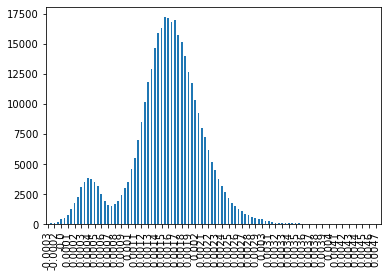

In [130]:
hist_plot = pd.Series({b_i:c_i for c_i, b_i in zip(c, b[:-1])})
hist_plot.plot(kind='bar')
plt.xticks(range(len(hist_plot))[::2], list(map(lambda x: round(x, 4), hist_plot.index))[::2]);

In [133]:
(inner_join_df
 .groupby(['entry_id_x', 'version_x', 'sent_idx_x', 'sent_idx_y', 'word_idx_x', 'token_x'])
 ['dot_product'].idxmax()
 .head(3)
)

entry_id_x  version_x  sent_idx_x  sent_idx_y  word_idx_x  token_x   
547989      0          0           0           0           WASHINGTON       0
                                               1           —              608
                                               2           Weapons       1216
Name: dot_product, dtype: int64

In [134]:
max_words = (inner_join_df
 .loc[lambda df: df.groupby(['entry_id_x', 'version_x', 'sent_idx_x', 'sent_idx_y', 'word_idx_x', 'token_x'])['dot_product'].idxmax()]
 [des_col_list]
 .groupby([
     'entry_id_x', 'version_x', 'sent_idx_x', 'version_y', 'sent_idx_y'
 ])['dot_product']
 .mean()
 .reset_index()
 .loc[lambda df: df.groupby(['entry_id_x', 'version_x', 'sent_idx_x', 'version_y'])['dot_product'].idxmax()]
 .sort_values('sent_idx_x')
#  .loc[lambda df: df['sent_idx_x'] != df['sent_idx_y']]
)

In [ ]:
num_sents = []
for entry_id, version, text in tqdm(df[['entry_id', 'version', 'summary']].itertuples(index=False), total=len(df)):
    num_sents.append({
        'entry_id': entry_id,
        'version': version,
        'num_sents': len(unp.split_sents(text))
    })

pd.concat([
    sent_dfp_dl.groupby(['entry_id', 'version']).apply(lambda df: len(df)).to_frame('dl'),
    sent_dfp_nondl.groupby(['entry_id', 'version']).apply(lambda df: len(df)).to_frame('nondl'),
    pd.DataFrame(num_sents).set_index(['entry_id', 'version'])['num_sents'].to_frame('spacy')
], axis=1).head()

In [ ]:
#                  CONCAT(word_emb.entry_id, '-', 
#                         word_emb.version, '-',
#                         word_emb_2.version, '-',
#                         word_emb.sent_idx, '-',
#                         word_emb_2.sent_idx, '-',
#                         word_emb.word_idx, '-',
#                         word_emb_2.word_idx, '-',
#                         word_emb.token, '-'
#                         )                                                            AS partition_key,